# Métodos numéricos para Advecção 1D e aplicações em dinâmica atmosférica

---

**Como entregar:** Enviar o seu jupyter notebook (.ipynb) pelo próprio Classroom. Uma cópia deste será automaticamente criada para você no seu Google Drive, você pode usar essa cópia mesmo, sem necessidade de criar outra. Ou pode baixar o notebook, rodar localmente, e depois carregar o notebook para entrega da atividade.


**Leia com atenção:**


*   Os exercícios que valem nota estão todos marcados uma exclamação❗.
*   Atividades marcadas com 🧩 são opcionais.
*   Use o Google Colab para executar o notebook e fazer a tarefa, ou baixe no seu computador e faça na API que preferir, mas lembre-se de entregar no Classroom a versão final.
*   Há questões dissertativas e questões computacionais! Responda com códigos e texto, nos campos indicados.
*   Entregue o notebook completo, com todo conteúdo original e mais os seus códigos e textos.
*   ❗Exercício 00:❗ Para mostrar que você leu até aqui, escreva seu nome completo (assinatura) na linha a seguir:




*Assinatura:*



---



## Preliminares

In [ ]:
import numpy as np                  #Numpy
import matplotlib.pyplot as plt     # Gráficos/figuras
import matplotlib.colors
from prettytable import PrettyTable #Tabelas mais bonitinhas



---




Parte teórica:
- LeVeque, Randall J. Finite volume methods for hyperbolic problems. Vol. 31. Cambridge university press, 2002.
- Strikwerda, John C. Finite difference schemes and partial differential equations. Society for Industrial and Applied Mathematics, 2004.
- Durran, Dale R. Numerical methods for fluid dynamics: With applications to geophysics. Vol. 32. Springer Science & Business Media, 2010.

Parte aplicada:
- Wicker, Louis J., and William C. Skamarock. "Time-splitting methods for elastic models using forward time schemes." Monthly weather review 130, no. 8 (2002): 2088-2097.

https://www.atmos.albany.edu/facstaff/rfovell/ATM562/wicker-skamarock-2002.pdf




---



## Introdução e Motivação

Uma parte essencial da dinâmica atmosférica/oceânica é o tratamento da advecção/transporte. Essa parte aparece tanto na questão de transporte de traçadores (umidade, polutentes, etc,..) quanto no núcleo dinâmico, com advecção de momentum e massa.

A ideia dessa aula é apresentar alguns conceitos fundamentais de métodos numéricos para advecção/transporte, começando com problemas 1D.



---



## Advecção e Conservação

Vamos começar vendo o problema de transporte com o olhar de Volumes Finitos. Como base seguiremos o livro do Randall LeVeque para esse primeiro pedaço:



Primeiro temos que entender o que é uma **Lei de Conservação**.

Vamos considerar que temos uma quantidade (um traçador, umidade, ou o próprio ar), cuja densidade vamos chamar de $u$. Assumiremos que a quantidade total dessa substância (massa total) em um instante de tempo em um certo **volume** (aqui, para simplificar, será um intervalo $[x_j, x_{j+1}]$, mas poderia ser 3D, com integrais triplas) é
$$
M_i(t) = \int_{x_j}^{x_{j+1}} u(t, x)\, dx.
$$

Vamos assumir que essa massa é conservada, ou seja, nada se perde ou é criado no interior do volume (intervalo). Mas podemos ter fluxo pelas laterais! Considere que entra no ponto $x_{j}$ uma quantidade $f(t,x_{j})$ por unidade de tempo, e sai uma quantidade $f(t,x_{j+1})$ em $x_{j}$, por unidade de tempo. Note que essas quantidades podem ser negativas, então pode entrar e sair substância de qualquer lado. $f$ é chamada de função de fluxo, e temos que a massa é conservada de forma a satisfazer:
$$
\frac{d M_j(t)}{dt} = f(u(t,x_{j}))- f(u(t,x_{j+1})).
$$
(Obs: o que entra tem sinal positivo, e o que sai, negativo, considerando o sentido do eixo x.)

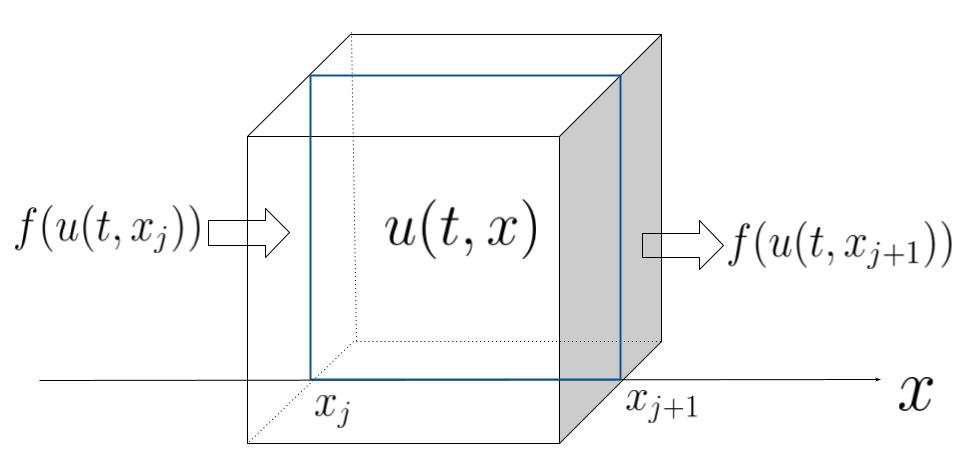

Usando o Teorema Funcamental do Cálculo, e sob certas hipóteses de $f$ e $u$, podemos escrever a equação de conservação da seguinte forma:
$$
\int_{x_j}^{x_{j+1}}\frac{\partial   u(t, x)}{\partial t}\, dx = - \int_{x_j}^{x_{j+1}} \frac{\partial f(u(t,x))}{\partial x} dx.
$$


Para que essa igualdade de integrais seja satisfeita para quaisquer $x_j$ e $x_{j+1}$, precisamos que

$$
\frac{\partial}{\partial t}   u(t, x) + \frac{\partial}{\partial x} f(u(t,x)) = 0.
$$



👉 Essa é a chamada **equação de lei de conservação**, que é a base a equação de adveção/transporte que estudaremos nesta aula! $f$ pode ser bem complicada, então aqui vamos começar vendo o caso linear.

## Diferenças Finitas

Nos problemas de nosso interesse, podemos mostrar que a função de fluxo costuma ter a forma:
$$
f(u(t, x)) = v(t,x) u(t,x),
$$
onde $v(t,x)$ é a velocidade do fluido que está carregando a substância (traçador), que assumiremos como conhecida. Nos exemplos a seguir começaremos com $v(t,x)=v$ constante!

Seja $u(t,x)$ uma função escalar que representa um tracador (ou a concentração de um traçador), que será transportado ao longo domínio (1D) com velocidade $v$, por hora assumida constante. Para o caso onde $f(u)=vu$, com $v$ constante, a equação que modela esse fenômeno é:
$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = 0,
$$
que precisa de condições iniciais ($u(t_0, x)=u^0(x)$) e condições de fronteira (assumindo $x\in [a,b]$). Para facilitar nossa apresentação, vamos assumir condições de fronteira periódicas ($u(t, a) = u(t,b), \text{se } x \in [a,b]$), ou de Dirichlet nula $u(t, a) = 0 = u(t,b), \text{se } x \in [a,b]$.


Ignorando as condições de fronteira (assumindo $x \in \mathbb{R}$), pode-se mostrar que a solução desse problema é dado por
$$
u(t,x)=u^0(x-v(t-t_0)).
$$
(🧩 Verifique!)

ou seja, há simplesmente um transporte da quantidade dada no tempo inicial ao longo do tempo, com velocidade $v$. Com as condições de fronteira, a solução complica um pouco, mas a estrutura de transporte da solução persiste (por exemplo, podem ocorrer reflexões na fronteira, complicando a "cara" da solução).




---



### Discretização do domínio


Primeiro, vamos subdividir o intervalo de tempo em $n$ subintervalos uniformemente espaçados, obtendo
 $$t_k=\frac{k}{n}(T-t_0)+t_0, \quad k=0, 1, ..., n.$$
 Chamaremos o passo de tempo de $h$,
 $$
h= \frac{T-t_0}{n}.
 $$

 Dividimos também o espaço em $m$ subintervalos uniformemente espaçados, obtendo
 $$x_j=\frac{j}{m}(b-a)+a, \quad j=0, 1, ..., m.$$
 Chamaremos o intervalo espacial entre pontos de $\Delta x$
 $$
\Delta x= \frac{b-a}{m}.
 $$

Agora, assumimos que $u^{k}_j$ aproxima a solução exata no tempo $t^k$ e ponto $x_j$, isto é
$$
u^{k}_j ≈ u(t^{k}, x_j).
$$

### Discretização da equação

Vamos começar com um método bem simples de discretizar essa equação, para vermos o seu comportamento.

Da definição de derivadas (noção de limites) podemos diretamente tirar a seguinte aproximação para a equação de advecção:
$$
\frac{u^{k+1}_j-u^{k}_j}{h}+v\frac{u^{k}_j-u^{k}_{j-1}}{\Delta x} = 0,
$$
pois note que, se $h$ e $\Delta x$ forem para zero, as diferenças vão para derivadas parciais. Similarmente, é possível deduzir esse métodos via séries de Taylor, que vão inclusive fornecer uma noção de erro da aproximação.

📚 A noção de convergência nesse caso é um pouco complicada, pois a indexação dos pontos no tempo e espaço vão mudando à medida que $h$ e $\Delta x$ ficam pequeno. Deixamos isso para o leitor curioso verificar nos livros de referência do curso.

### Fronteira

Nas fronteiras temos que
$$u(t,a) \approx u_0^k, \quad u(t,b) \approx u_m^k.$$

No caso de condições nulas na fronteira (Dirichlet nulo), basta tomar $u_0^k=0=u_m^k$. Para imitar algumas coisas que vão aparecer na esfera mais adiante no curso, vamos seguir adiante usando **condições de fronteira periódicas**:
$$u(t,a) = u(t,b).$$

Numericamente, as condições de fronteira periódicas de traduzem como simplesmente
$$ u_0^k=u_m^k.$$
Porém, temos que ter cuidado com a direção de transporte na hora de implementar tal condição.



### 💻 Exemplo - Trasnporte 1D 💻

Vamos resolver o seguinte problema:
$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = 0, \quad x \in (0,1), \quad t \in (0, 1),
$$
com
$$
u(t,0)=u(t,1)\,\quad \text{(fronteira periódica)}\\
u(0,x)= u^0(x)\,\quad \text{(condição inicial)}\\
$$
onde a condição inicial é dada por
$$
u^0(x) = \frac{1}{1+e^{(80(|x-0.5|-0.15)}}
$$
e
$$
v=1.
$$

(Este problema é o mesmo proposto em Wicker & Skamarock 2002)

In [ ]:
#Definição do domínio
#---------------------

 # Para facilitar vou fazer disso uma classe,
 #  pois assim fica fácil de passar parâmetros para funções
class Dominio:
  def __init__(self, t0=0.0, T=1.0, a=0.0, b=1.0, h=0.008, dx=0.02, n=None, m=None):
     #Valores default usados em Wicker & Skamarock 2002

    self.t0 = t0   #Tempo inicial (segundos)
    self.T = T     #Tempo final (segundos)
    self.a = a     #Extremo esquerdo no espaço (metros)
    self.b = b     #Extremo direito no espaço (metros)

    #Discretização no tempo
    if n==None:
      n = (T-t0)/h
      if not n.is_integer():
        print("Cuidado! Com esse h o número de passos de tempo não é inteiro!!")
        print("  dt usado: ", (T-t0)/(int((T-t0)/h)))
    else:
      h = (T-t0)/n
      print("Calculando h baseado no n dado. h = ", h)

    self.n = int((T-t0)/h)                #Número de passos no tempo
    self.t = np.linspace(t0, T, self.n+1)  #Tempos discretos

    #Discretização no espaço
    if m==None:
      m = (b-a)/dx
      if not m.is_integer():
        print("Cuidado! Com esse dx o número de pontos no espaço não é inteiro!!")
        print("  dx usado:", (b-a)/(int((b-a)/dx)))
    else:
      dx = (b-a)/m
      print("Calculando dx baseado no m dado. dx = ", dx)

    self.m = int((b-a)/dx)                #Número de pontos no espaço
    self.x = np.linspace(a, b, self.m+1)  #Pontos no espaço

    self.h = (T-t0)/n     #Passo de tempo (segundos)
    self.dx = (b-a)/m   #Intervalo espacial (metros)



In [ ]:
#Definição do problema
#---------------------

class TransporteEscalar:
  def __init__(self, v = 1.0):
    self.v = v #Velocidade do vento (constante - m/s)

  def u0(self, x):  #Condição inicial (concentração do tracador)
    # Condição inicial de Strikwerda
    #return np.heaviside(x+1.0, 0.5)*(1-np.heaviside(x-1.0, 0.5))*(1-np.abs(x))

    # Condição inicial de Wicker & Skamarock 2002
    z = np.abs(x-0.5)
    exp = np.exp(80*(z-0.15))
    return 1/(1+exp)

  def sol(self, t, x):
    #Dado um tempo t fixado, a solução é simplesmente a translação da condição inicial
    # com velocidade v
    return self.u0(x-self.v*t)

In [ ]:
#Agora vamos criar um domínio específico e problema
dom = Dominio(t0=0, T=1, a=0, b=1, h=0.008, dx=0.02)
prob = TransporteEscalar(v = 1.0)

In [ ]:
# Gráficos
figure, axs = plt.subplots(figsize=(10,8))
plt.plot(dom.x, prob.u0(dom.x), '-', label="Cond. Inicial", linewidth=1)
plt.xlabel("x")
plt.ylabel("u")
plt.grid()
plt.legend()
plt.show()



---



Vamos considerar este método,
$$
\frac{u^{k+1}_j-u^{k}_j}{h}+v\frac{u^{k}_j-u^{k}_{j-1}}{\Delta x} = 0,
$$
que conhecido como "upwind" no caso de $v>0$. Na prática, o método é implementado como
$$
u^{k+1}_j=u^{k}_j-\frac{v h}{\Delta x} (u^{k}_j-u^{k}_{j-1}), \quad j=1,2,3...m.
$$
Nas fronteiras, se vamos usar condições periódicas, temos que fazer:
$$
u^k_{0}=u^k_{m},
$$
toda vez que o índice $j-1$ alcançar $0$ (ou seja, quando $j=1$). Portanto, o valor de $u^k_{0}$ é sempre prescrito exatamente igual ao $u^k_{m}$ calculado.

📚 A noção de "upwind" vem do fato de que o transporte está levando o traçadores para a direita no caso de $v>0$, e nossa discretização no espaço pega para discretização o valor no ponto a esquerda ($x_{j-1}$), logo "upwind"/"upstream" (à montante).

📚 O número $λ = \frac{v h}{\Delta x}$ é chamado de **número de Courant** e será bem importante mais adiante.

In [ ]:
def upwind(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)
  print("Número de Courant:", lam)
  for k in range(dom.n): #loop no tempo
    u[1:dom.m+1,k+1] = u[1:dom.m+1,k] - lam*(u[1:dom.m+1,k]-u[0:dom.m,k])
    u[0,k+1] = u[dom.m,k+1]
  return u


In [ ]:
#Vamos re-criar aqui nosso domínio específico e problema,
#   por conveniencia de apresentação
dom = Dominio(t0=0, T=1, a=0, b=1, h=0.02, dx=0.02)
prob = TransporteEscalar(v = 1.0)

#Nossa solução numérica
u = upwind(dom, prob)


In [ ]:
# Gráficos
figure, axs = plt.subplots(figsize=(10,6))
plt.plot(dom.x, u[:,0], label="t0", linewidth=1)
plt.plot(dom.x, u[:,1], label="t1", linewidth=1)
plt.plot(dom.x, u[:,2], label="t2", linewidth=1)
plt.plot(dom.x, u[:,3], label="t3", linewidth=1)
plt.plot(dom.x, u[:,10], label="t10", linewidth=1)
plt.xlabel("x")
plt.ylabel("u")
#plt.grid()
plt.legend()
plt.show()

📚 Interpretando fisicamente: O resultado observado mostra a onda se propagando com velocidade 1m/s exatamente. Repare que passados 10 passos de tempo (cada um de 0.01s), o perfil inicial se deslocou 0.1 metro no espaço, exatamente.

📚 Note que não houve erro no método numérico!!! Isso é uma particularidade por termos um problema linear e usarmos o número de Courant = 1. Mas não confie nisso...

In [ ]:
#Vamos reduzir o passo no tempo (h)
dom = Dominio(t0=0, T=1, a=0, b=1, h=0.008, dx=0.02)
prob = TransporteEscalar(v = 1.0)

#Nossa solução numérica
u = upwind(dom, prob)

# Gráficos

figure, axs = plt.subplots(figsize=(10,6))
plt.plot(dom.x, u[:,0], label="t0", linewidth=1)
plt.plot(dom.x, u[:,1], label="t1", linewidth=1)
plt.plot(dom.x, u[:,2], label="t2", linewidth=1)
plt.plot(dom.x, u[:,3], label="t3", linewidth=1)
plt.plot(dom.x, u[:,10], label="t10", linewidth=1)
plt.plot(dom.x, u[:,20], label="t20", linewidth=1)
plt.xlabel("x")
plt.ylabel("u")
#plt.grid()
plt.legend()
plt.show()

📚 Vemos a onda sendo transportada, mas observamos claramente que ela está sendo difundida! Isso é uma caracteristica clássica de métodos "upwind": difusão do sinal.

Como estamos usando uma condição periódica de fronteira, após um certo período de tempo o sinal deveria voltar exatamente para sua posição original, sem perda de formato. Vejamos um caso desses:

In [ ]:
#Vamos dar duas voltas completas (T=2)
dom = Dominio(t0=0, T=2, a=0, b=1, h=0.008, dx=0.02)
prob = TransporteEscalar(v = 1.0)

#Nossa solução numérica
u = upwind(dom, prob)

# Gráficos
figure, axs = plt.subplots(figsize=(10,6))
plt.plot(dom.x, u[:,0], label="t0", linewidth=1)
plt.plot(dom.x, u[:,125], label="t125", linewidth=1) # 1 volta completa
plt.plot(dom.x, u[:,250], label="t250", linewidth=1) # 2 voltas completas
plt.xlabel("x")
plt.ylabel("u")
#plt.grid()
plt.legend()
plt.show()

Vejamos um caso onde o número de Courant é maior que 1.

In [ ]:
#Vamos manter dx e aumentar o h
dom = Dominio(t0=0, T=1, a=0, b=1, h=0.04, dx=0.02)
prob = TransporteEscalar(v = 1.0)

#Nossa solução numérica
u = upwind(dom, prob)

# Gráficos

figure, axs = plt.subplots(figsize=(10,6))
plt.plot(dom.x, u[:,0], label="t0", linewidth=1)
plt.plot(dom.x, u[:,1], label="t1", linewidth=1)
plt.plot(dom.x, u[:,2], label="t2", linewidth=1)
plt.plot(dom.x, u[:,3], label="t3", linewidth=1)
plt.plot(dom.x, u[:,4], label="t4", linewidth=1)
#plt.plot(dom.x, u[:,10], label="t10", linewidth=1)
plt.xlabel("x")
plt.ylabel("u")
#plt.grid()
plt.legend()
plt.show()

📚 Neste caso a solução ficou instável e tende a crescer (e "explodir") com o passar do tempo! O que está acontecendo?



---



---



### Condição de estabilidade (CFL)

📚 A Condição de Courant-Friedrichs-Lewy (CFL) é uma condição necessária para que esquemas numéricos explícitos para problemas hiperbólicos (e.g. ondas, transporte) sejam estáveis.

📚 A definição matemática de estabilidade neste caso de EDPs exige um pouco mais de rigor (comparado ao de EDOs), e vamos deixar a cargo do leitor (vide o livro Strikwerda). Para nossos propósitos atuais, nos importa saber que um método estável é aquele que a solução não explode (cresce exponencialmente) com o tempo.

📚 Uma forma bastante intuitiva de entender o conceito da condição de CFL, importantíssima para nossas aplicações de interesse, é, de forma não rigorosa, a seguinte:
> Para que um esquema numéricos explícito no tempo para um problema hiperbólico seja estável, é necessário que o domínio de dependência do problema contínuo esteja contído no domínio de dependência numérica.

📚 O domínio de dependência do problema contínuo é o conjunto de pontos no espaço/tempo (passado) contendo informações necessárias para calcularmos a solução analítica em um certo ponto no espaço/tempo.

📚 O domínio de dependência numérico é o conjunto de pontos no espaço/tempo (passado) contendo informações usadas pelo método numérico para calcularmos a solução aproximada em um certo ponto no espaço/tempo.


📚 Na prática, para o nosso problema em questão e muitos dos métodos de interesse onde usamos um stencil pequeno no espaço (apenas vizinhos mais próximos), isso se resume a exigir que o número de Courant seja tal que
$$
|\lambda| = | v h / \Delta x | \leq 1.
$$

Vejamos um exemplo prático a seguir para o upwind.

### 💻 Exemplo - CFL 💻

In [ ]:
# Domínio numérico
dom = Dominio(t0=0, T=1, a=0, b=1, h=0.05, dx=0.04)

#Problema
prob = TransporteEscalar(v = 1.0)

#Vamos rastrear que informações são usadas para chegarmos na solução no ponto
# Que informação foi usada para chegar em u(t_ref, x_ref)?
t_ref = 0.5 # Deve ser um múltiplo de h
x_ref = 1.0  # Pode ser qualquer coisa no intervalo, mas fica melhor se estiver perto do extremo esquerdo

# Trajetória exata
#---------------------------------------------

#Trajetória exata até o t_ref/x_ref (velocidade constante)
# v = (x(t) - x(0))/ (t-t0)
# x(0) = x(t) - v (t-t0)
x0 = x_ref - prob.v*(t_ref - dom.t0) #A informação relevante mora nesse ponto em t=0

#Caminho até lá (trajetória exata da informação partindo de t=0 e x0 até t_ref e x_ref)
xt = x0 + prob.v * dom.t

#Vamos tirar do gráfico tudo que está além do tempo t_ref e olhar só o passado [t0, t_ref]
t_ref_ind = np.argmax(dom.t>t_ref)
xt[t_ref_ind+1:] = np.nan

# Ponto usados no método numérico para chegar em t_ref e x_ref
#------------------------------------------

#Apartir de x_ref, t_ref, vamos voltando em cada passo de tempo
#  e marcando os pontos x que usamos no método upwind.
t_num = dom.t[:t_ref_ind][::-1] #Todos os tempos até t_ref em ordem reversa
x_num = [None]*len(t_num)       #Aqui vamos guardar os
x_num[0] = [x_ref]
for i in range(1,len(t_num)):
  x_num[i] = []
  for x in x_num[i-1]:
    # em cada passo de tempo o método upwind usa os pontos do passo anterior
    # logo abaixo e a esquerda (k, j-1) e (k, j) -> (k+1, j)
    x_num[i].append(x)
    x_num[i].append(x-dom.dx)

#------------------------------------------------

#Gráficos
figure, axs = plt.subplots(figsize=(10,6))
plt.plot(xt, dom.t, label="Trajetória Exata", linewidth=1)
for i, t in enumerate(t_num):
  for x in x_num[i]:
    plt.plot(x, t, "g.", linewidth=1)
plt.plot(x, t, "g.", linewidth=1, label="Pontos numéricos")
plt.plot(1, 0.5, "bx", label="(t=0.5,x=1.0)", linewidth=1)
plt.plot(0.5, 0.0, "ro", label="Dado inicial ($u^0(x_0)$)", linewidth=1)
plt.xlabel("x")
plt.ylabel("t")
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 0.8])

#plt.grid()
plt.legend()
plt.show()
lam = prob.v*dom.h/dom.dx
if lam > 1 :
  stab = "(Instável)"
else :
  stab = "(Potencial de ser estável)"
print("Número de Courant = ", prob.v*dom.h/dom.dx, stab )

🧩 Varie os valores de $\Delta x$ e $h$ e verifique se o domínio de dependência do problema contínuo (reta azul) fica dentro ou fora da região de dependência numérica (formada pela região que engloba os pontos verdes).

Observe que os pontos verdes só encobrem a reta azul quando $|\lambda | < 1$ !!!



---



---



### Métodos Clássicos

Vejamos alguns outros métodos interessantes para o mesmo problema. Aqui assumimos sempre $v>0$.

* (upwind)  $$
\frac{u^{k+1}_j-u^{k}_j}{h}+v\frac{u^{k}_j-u^{k}_{j-1}}{\Delta x} = 0,
$$

$$
u^{k+1}_j=u^{k}_j-\lambda (u^{k}_j-u^{k}_{j-1}),
$$

*  (downwind) $$
\frac{u^{k+1}_j-u^{k}_j}{h}+v\frac{u^{k}_{j+1}-u^{k}_{j}}{\Delta x} = 0,
$$

$$
u^{k+1}_j=u^{k}_j-\lambda (u^{k}_{j+1}-u^{k}_{j}),
$$


*  (centrado) $$
\frac{u^{k+1}_j-u^{k}_j}{h}+v\frac{u^{k}_{j+1}-u^{k}_{j-1}}{2\Delta x} = 0,
$$

$$
u^{k+1}_j=u^{k}_j-\lambda (u^{k}_{j+1}-u^{k}_{j-1})/2,
$$


*  (Leap-frog) $$
\frac{u^{k+1}_j-u^{k-1}_{j}}{2h}+v\frac{u^{k}_{j+1}-u^{k}_{j-1}}{2\Delta x} = 0,
$$


$$
u^{k+1}_j=u^{k-1}_j-\lambda (u^{k}_{j+1}-u^{k}_{j-1}),
$$


*  (Lax-Friedrichs) $$
\frac{u^{k+1}_j-(u^{k}_{j-1}+u^{k}_{j+1})/2}{h}+v\frac{u^{k}_{j+1}-u^{k}_{j-1}}{2\Delta x} = 0,
$$

$$
u^{k+1}_j=(1-\lambda) u^{k}_{j+1}/2+(1+\lambda)u^{k}_{j-1}/2,
$$

Note que o Leapfrog requer 2 passos de tempo anteriores para avançar!

Vamos usar condições periódicas de fronteira, então isso precisa ser cuidadosamente implementado para cada método de forma a garantir que
$$
u_0^k=u_m^k.
$$

In [ ]:
def exata(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução exata

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  for k in range(dom.n+1): #loop no tempo
    # O fmod é usado aqui para garantir a periodicidade no espaço (b-a)
    u[:,k] = prob.u0(np.divmod(dom.x-prob.v*dom.t[k], dom.b-dom.a)[1])

  return u

def upwind(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)

  for k in range(dom.n): #loop no tempo
    #Meio do domínio + fronteira direita
    u[1:dom.m+1,k+1] = u[1:dom.m+1,k] - lam*(u[1:dom.m+1,k]-u[0:dom.m,k])
    #Fronteira esquerda
    u[0,k+1] = u[dom.m,k+1]

  return u

def downwind(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)

  for k in range(dom.n): #loop no tempo
    #Meio do domínio + fronteira esquerda
    u[0:dom.m,k+1] = u[0:dom.m,k] - lam*(u[1:dom.m+1,k]-u[0:dom.m,k])
    #Fronteira direita
    u[dom.m,k+1] = u[0,k+1]

  return u

def centrado(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)

  for k in range(dom.n): #loop no tempo
    #Meio do domínio
    u[1:dom.m,k+1] = u[1:dom.m,k] - lam*(u[2:dom.m+1,k]-u[0:dom.m-1,k])/2.0
    #Fronteira esquerda
    u[0,k+1] = u[0,k] - lam*(u[1,k]-u[dom.m-1,k])/2.0
    #Fronteira direita
    u[dom.m,k+1] = u[0,k+1]

  return u

def leapfrog(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)

  #  Vou usar um método de passo único inicialmente!

  #Centrado?
  #u[1:dom.m,1] = u[1:dom.m,0] - lam*(u[2:dom.m+1,0]-u[0:dom.m-1,0])/2.0
  #u[0,1] = u[0,0] - lam*(u[1,0]-u[dom.m,0])/2.0
  #u[dom.m,1] = u[0,1]

  #upwind?
  u[1:dom.m+1,1] = u[1:dom.m+1,0] - lam*(u[1:dom.m+1,0]-u[0:dom.m,0])
  u[0,1] = u[dom.m,1]

  for k in range(1, dom.n): #loop no tempo
    #Meio do domínio
    u[1:dom.m,k+1] = u[1:dom.m,k-1] - lam*(u[2:dom.m+1,k]-u[0:dom.m-1,k])
    #Fronteira esquerda
    u[0,k+1] = u[0,k-1] - lam*(u[1,k]-u[dom.m-1,k])
    #Fronteira direita
    u[dom.m,k+1] = u[0,k+1]

  return u

def laxfriedrichs(dom, prob):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)

  for k in range(dom.n): #loop no tempo
    #Meio do domínio
    u[1:dom.m,k+1] = (1-lam)*u[2:dom.m+1,k]/2.0+(1+lam)*u[0:dom.m-1,k]/2.0
    #Fronteira esquerda
    u[0,k+1] = (1-lam)*u[1,k]/2.0+(1+lam)*u[dom.m-1,k]/2.0
    #Fronteira direita
    u[dom.m,k+1] = u[0,k+1]

  return u

### 💻 Exemplo - métodos 💻

In [ ]:
dom = Dominio(t0=0, T=2, a=0, b=1, n=250, m=50)
prob = TransporteEscalar(v = 1.0)
lam = prob.v * dom.h/dom.dx
print("Número de Courant = ", lam)

#Nossas soluções numéricas e exata
u_exata = exata(dom, prob)
u_upwind = upwind(dom, prob)
#u_downwind = downwind(dom, prob)
#u_centrado = centrado(dom, prob)
u_leapfrog = leapfrog(dom, prob)
u_laxfriedrichs = laxfriedrichs(dom, prob)

# Gráficos
it = 30 #int(dom.n/2)
figure, axs = plt.subplots(figsize=(15,8))
plt.plot(dom.x, prob.u0(dom.x), label="u0", linewidth=1)
plt.plot(dom.x, u_upwind[:,it], label="upwind", linewidth=1)
#plt.plot(dom.x, u_downwind[:,it], label="downwind", linewidth=1)
#plt.plot(dom.x, u_centrado[:,it], label="centrado", linewidth=1)
plt.plot(dom.x, u_leapfrog[:,it], label="leapfrog", linewidth=1)
plt.plot(dom.x, u_laxfriedrichs[:,it], label="laxfriedrichs", linewidth=1)
plt.plot(dom.x, u_exata[:,it], "-.", label="exata", linewidth=1)
plt.title("Solução na iteração temporal : "+str(it))
plt.xlabel("x")
plt.ylabel("u")
#plt.grid()
plt.legend()
plt.show()

Conclusões:
* Satisfazer CFL não garante estabilidade (veja o método centrado)
* Leap-frog tem um modo computacional no tempo (tempos pares desacoplam dos ímpares!) - parasitic mode!
* Métodos de transporte podem naturalmente criar difusão!

🧩 Varie a discretização (variando $h$ e $\Delta x$, ou $n$ e $m$) e verifique que a condição de CFL é de fato necessária para todos os métodos estudados aqui!

🧩 Verifique que a quantidade de difusão do método é sensível ao número de Courant ($\lambda$)

📚 Até aqui, só discutimos métodos explícitos, onde o próximo passo de tempo pode ser explicitamente calculado a partir do anterior. Métodos implíticos também são interessantes. Nestes, a cada passo de tempo é necessário resolver um sistema (linear neste caso, mas podendo ser não linear em casos reais) para obter a próxima atualização no tempo.

📚 Não vamos abordar métodos implícitos no tempo neste curso, pois os modelos aplicados que vamos estudar usam métodos explícitos. No caso de métodos implícitos, a condição de CFL é mais facilmente realizada para qualquer número de Courant ($\lambda$), pois a cada passo de tempo o método usa toda a informação do passo anterior, então o domínio de dependência do problema contínio certamente estará coberto pelo numérico. Isso é atrativo, pois podemos dar passos de tempo bem maiores! Mas pagamos o preço de resolver um sistema a cada passo (linear ou não-linear).

🧩 Teste de convergência

Vamos reduzir o passo de tempo e espaço e verificar se a solução está convergindo para a teórica esperada.

In [ ]:
#Tabela
print("Erros")
tab = PrettyTable(['n', 'm', 'Upwind', "Leapfrog", "Lax-Friedrichs"])

for l in range(0,7):
  #Vamos dobrar o número de passos de tempo e o
  # número de pontos no espaço em cada iteração (2^l)
  dom = Dominio(t0=0, T=1, a=0, b=1, n=100*2**l, m=90*2**l)
  prob = TransporteEscalar(v = 1.0)
  lam = prob.v * dom.h/dom.dx
  print(l, " Número de Courant = ", lam)

  #Nossos erros máximos
  u_exata = exata(dom, prob)
  erro_upwind = np.max(np.abs(upwind(dom, prob)-u_exata))
  erro_leapfrog = np.max(np.abs(leapfrog(dom, prob)-u_exata))
  erro_laxfriedrichs = np.max(np.abs(laxfriedrichs(dom, prob)-u_exata))
  tab.add_row([dom.n, dom.m, erro_upwind, erro_leapfrog, erro_laxfriedrichs])

  print(tab)

Observação: Se tiver curiosidade, verifique no Strikwerda que o a ordem de convergencia esperada neste teste é:
* Upwind: $O(h)+O(\Delta x)$ - portanto 1a ordem nesse experimento
* Leapfrog: $O(h^2)$ - portanto 2a ordem nesse experimento
* Lax-Friedrich: $O(h^2/\Delta x)$ - portanto 1a ordem nesse experimento




---



## Volumes Finitos

#### Teoria Inicial

Vamos nos debruçar agora a analisar o método proposto em Wicker e Skamarock (2002), mas com uma notação um pouco diferente, para usarmos que fizemos até aqui.


Retornamos à equação na forma conservativa, dada a partir de uma função de fluxo.
$$
\frac{\partial}{\partial t}   u(t, x) + \frac{\partial}{\partial x} f(u(t,x)) = 0,
$$
resumidamente,
$$
\frac{\partial u}{\partial t}  = - \frac{\partial f(u) }{\partial x}  ,
$$



Integrando agora em um volume de controle (nosso *Volume Finito*) no intervalo de tamanho $\Delta x$ centrado em $x_j$, $[x_{j-1/2}, x_{j+1/2}]$, com $x_{j+1/2}=(x_{j}+x_{j+1})/2$, $x_{j-1/2}=(x_{j}+x_{j-1})/2$, e dividindo pelo tamanho do intervalo ($\Delta x$) temos

$$
\frac{1}{\Delta x}\int_{x_{j-1/2}}^{x_{j+1/2}}\frac{\partial   u(t, x)}{\partial t}\, dx = -\frac{1}{\Delta x} \int_{x_{j-1/2}}^{x_{j+1/2}} \frac{\partial f(u(t,x))}{\partial x} dx.
$$


Assim,

$$
\frac{\partial }{\partial t} \left(\frac{1}{\Delta x}\int_{x_{j-1/2}}^{x_{j+1/2}} u(t, x)\, dx\right) = -\frac{1}{\Delta x}  \left(f(u(t,x_{j+1/2}))- f(u(t,x_{j-1/2})) \right).
$$

onde estamos definindo a média de $u$ no Volume Finito,
$$
U_j(t)=\frac{1}{\Delta x}\int_{x_{j-1/2}}^{x_{j+1/2}} u(t, x)\, dx
$$
para concluir que

$$
\frac{\partial }{\partial t} U_j(t) = -\frac{1}{\Delta x}  \left(f(u(t,x_{j+1/2}))- f(u(t,x_{j-1/2})) \right).
$$

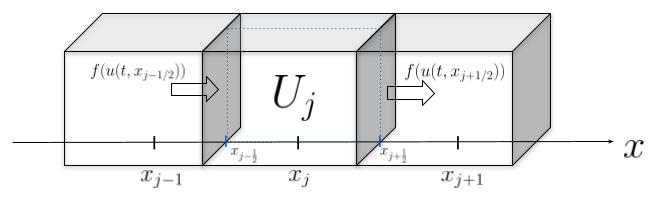

👉 Note que até aqui não há aproximações!!!! Estamos apenas dizendo exatamento como evolui a média de $u$ em volumes de controles!



---



Vamos assumir que $f(u(t,x))=v u(t,x)$ como antes, mas manter o $v$ dentro da derivada (isso vai ajudar a pensarmos no método mais geral, com $v$ variando no tempo e espaço), lembrando que $u$ é nosso traçador (sua concentração, por exemplo), e $v$ a velocidade do meio em que ele se encontra.

Um primeira aproximação que vamos fazer com a equação é assumir que a média é uma boa estimativa para o valor pontual, isto é, $U_j(t)\approx u(t, x_j)$, assim, $U_j(t_k) \approx u^{k}_j$. Essa é uma aproximação de segunda ordem em malhas uniformes (tem erro $O(\Delta x ^2)$ se $x_j$ for o centro de massa do volume de controle!).

👉 Essa noção de média será essencial em Volumes Finitos, e vai aperecer diversas vezes mais adiante no curso!

Portanto, agora podemos propor um método agora pensando na função de fluxo, discretizando a equação como,
$$
\frac{u^{k+1}_j-u^{k}_j}{h}=-\frac{F^{k}_{j+1/2}-F^{k}_{j-1/2}}{\Delta x},
$$
onde os $F^{k}_{j\pm 1/2}$ são estimativas dos fluxos ($f(u(t,x))=v u(t,x)$) no tempo $t_k$ em pontos intermediários da malha $x_{j+1/2}=(x_{j}+x_{j+1})/2$, $x_{j-1/2}=(x_{j}+x_{j-1})/2$. Isso assume uma noção pequenos "volumes" para cada ponto de malha $x_j$, e é o conceito chave para entender volumes finitos. Esse conceito é análogo ao de malha deslocada (malha tipo C) comum em diferenças finitas (vamos dicutir um pouco disso mais adiante no curso).

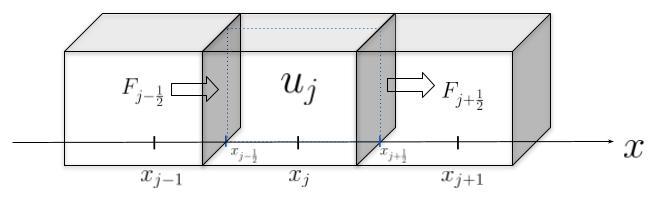

#### Método do MPAS

Um desafio em volumes finitos é como estimar esses fluxos $F^{k}_{j\pm 1/2}$. Em 1D isso é relativamente simples. Em Wicker & Skamarock, é proposto um método de 4a ordem que estima os fluxos como:
$$
F^{k}_{j-1/2}(u^k) =\frac{v^k_{j-1/2}}{12}[7(u^k_j+u^k_{j-1})-(u^k_{j+1}+u^k_{j-2})],
$$
onde note que usamos o valor da velocidade em um ponto intermediário, isto é, $v^k_{j-1/2}=v(t_k, x_{j-1/2})=v(t_k, (x_{j-1}+x_{j})/2)$, que é assumido conhecido e em geral poderia variar no tempo e espaço. Analogamente,
$$
F^{k}_{j+1/2}(u^k) =\frac{v^k_{j+1/2}}{12}[7(u^k_{j+1}+u^k_{j})-(u^k_{j+2}+u^k_{j-1})].
$$

Isso aparece no artigo como ( 👉 Note que usamos uma notação diferente, nosso $v$ é o $u$ do artigo, e nosso $u$ é o $q$ do artigo. Por que optamos por essa notação diferente do artigo? Saberemos nos próximos capítulos...)

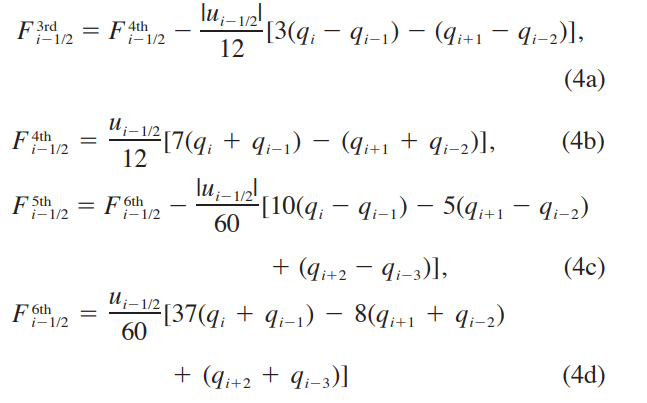

Bom, então agora estamos prontos para implmentar o método proposto, certo?
$$
\frac{u^{k+1}_j-u^{k}_j}{h}=-\frac{F^{k}_{j+1/2}-F^{k}_{j-1/2}}{\Delta x}.
$$
Infelizmente, esse método conforme proposto acima é bastante problemático, principalmente em 2 sentidos:
* Tem apenas ordem 1 na discretização temporal
* Será instável, como o método centrado que vimos anteriormente

A proposta de Wicker & Skamarock é trocar essa discretização de 1a ordem por um Runge-Kutta de 3 estágios, que vimos na aula passada.

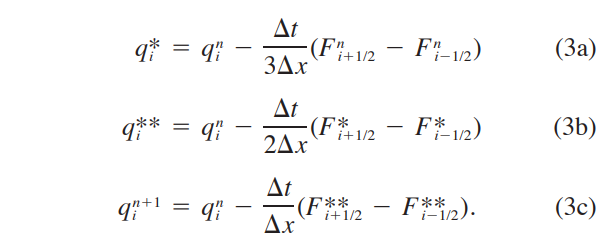

Na notação da aula anterior, temos que o método poderia ser escrito como:
$$
u^{k+1}=u^k+h f(u^{**}),
$$
$$
u^{**} = u^k + \frac{h}{2} f(u^{*}) \\
u^{*} = u^k + \frac{h}{3} f(u^k) \\
$$
mas cuidado, pois esse $f$ era o termo de tendência da EDO ($u' = f(u)$)!!!! Portanto, esse $f$, em um ponto $x_j$, pode ser obtido usando nossos fluxos:
$$
f(u) = -\frac{F_{j+1/2}(u) -F_{j-1/2}(u)}{\Delta x}.
$$

🧩 Verifique que substiruindo a expressão de $f$ nas expressões de $u^{k+1}$, $u^*$, $u^{**}$ obtemos exatamente o que está no paper, na nossa notação (com $q→u$ e $u→v$)!




---



### 💻 Implementação 💻

Vamos tentar fazer uma implementação aqui que se assemelhe do que é feito no MPAS.

* O tamanho do passo de integração em cada estágio é guardado em rk_timestep

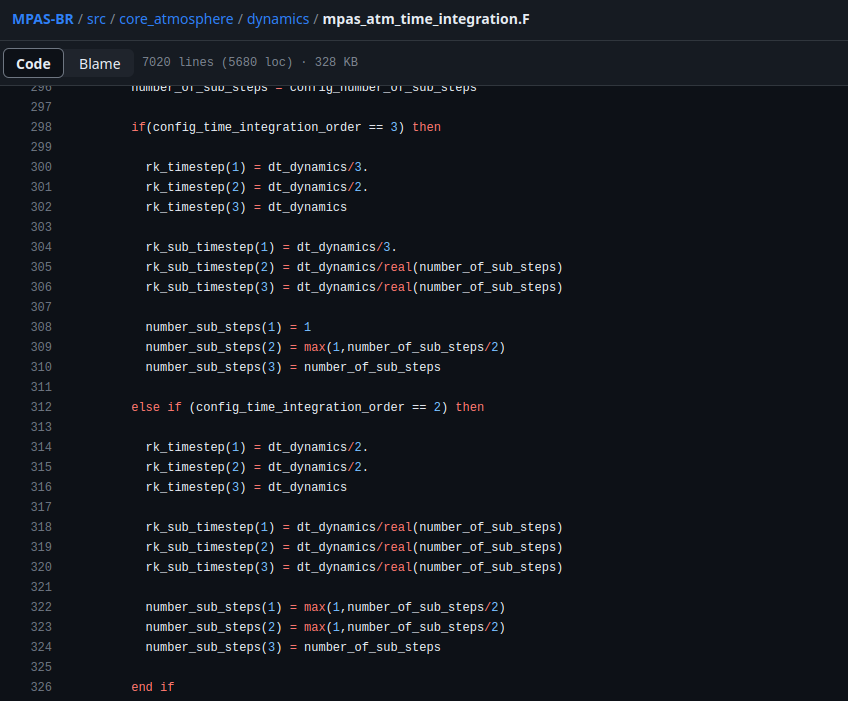

* Este é o loop dos estágios do Runge-Kutta (há um if no caso do 3o estágio por conta do sub-cycling de ondas acústicas, que não discutimos aqui)

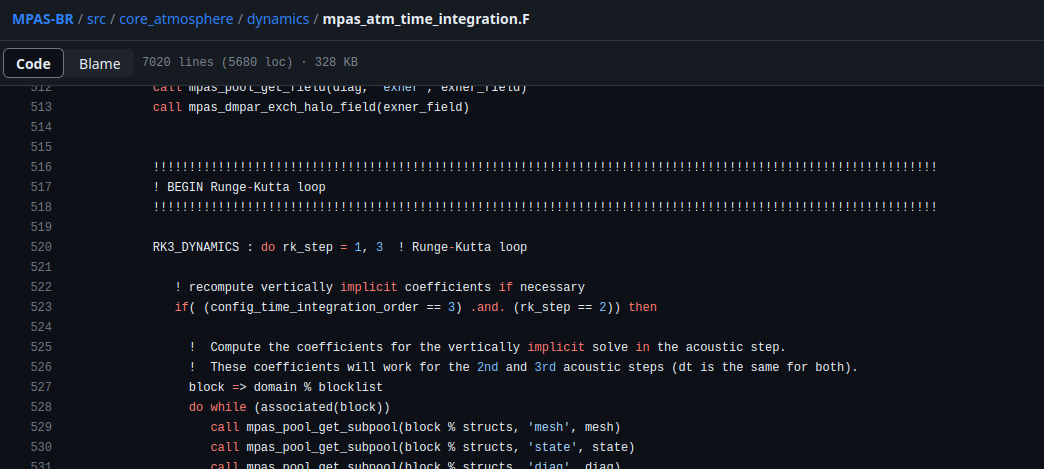

* O cálculo da $f$ é uma chamada de função de "tendências" (tend)

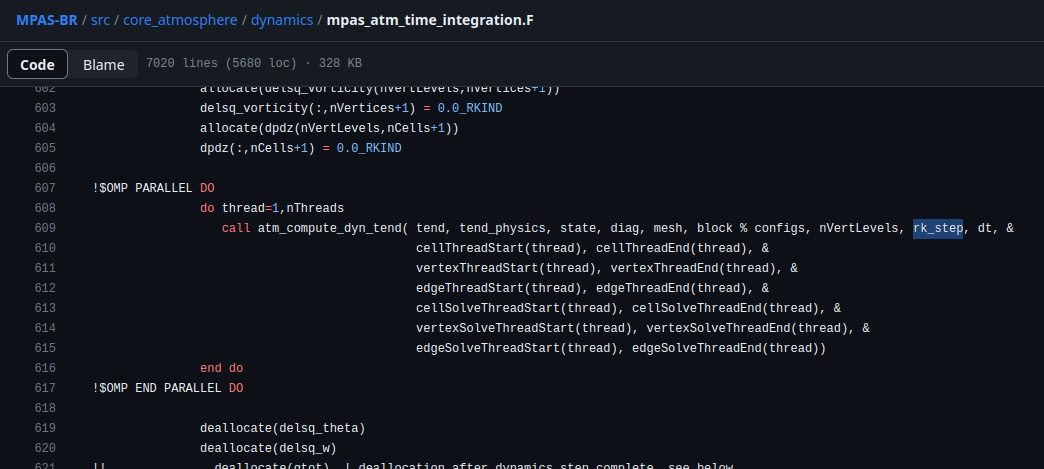

Vamos tentar imitar algo similar:

In [ ]:
## O método de Runge-Kutta 3 3 do MPAS
## Realiza 1 passo no tempo de tamanho h
## partindo da condição u0
def rk33mpas_1step(u0, tend, dom, prob):
  u = np.copy(u0)
  h = dom.h
  h_step = [h/3.0, h/2.0, h]
  for s in range(3): #loop dos estágios RK
    u = u0+h_step[s] * tend(u, dom, prob)
  # Note que não precisamos salvar os estágios, mas precisamos salvar o ponto de partida
  return u


## Nossa tendencia usando fluxos
def tend_4ord(u, dom, prob):
  # Vetor de fluxos
  F = np.empty((dom.m)) #Tem 1 elemento a menos que o u, pois está nas interfaces
                              # O elemento 0 desse vetor, equivale ao 0+1/2
                              # O elemento 1 desse vetor, equivale ao 1+1/2
                              # Veja como fica distribuição:
  #
  #    |------F0--------|------F1--------|------F2--------|- ... -|------F(m-2)---------|------F(m-1)--------|
  #    x0     x1/2     x1     x3/2      x2     x5/2     x3   ... x(m-2)  x(m-3/2)      x(m-1)  x(m-1/2)      xm
  #
  #  Lembrado que x0=xm, pelas condições periódicas de fronteira!!!!

  # Operador de 4a ordem
  #----------------------
  #Parte interna do domínio, F1 até F(m-2)
  #  --> note que o python sempre ignora o final dos ranges!
  #      Então 1:m-1 considera de 1 até m-2
  #            0:m+1 considera de 0 até m
  F[1:dom.m-1] = (prob.v/12.0)*(7*(u[1:dom.m-1]+u[2:dom.m]) - (u[3:dom.m+1]+u[0:dom.m-2]))
  #Fronteiras Periódicas
  F[0] = (prob.v/12.0)*(7*(u[0]+u[1]) - (u[2]+u[dom.m-1]))
  F[dom.m-1] = (prob.v/12.0)*(7*(u[dom.m-1]+u[dom.m]) - (u[1]+u[dom.m-2]))

  utend = np.empty_like(u)
  # Interior, x1,...x(m-1)
  utend[1:dom.m] = -(1/dom.dx)*(F[1:dom.m]-F[0:dom.m-1])
  # Borda esquerda
  utend[0] = -(1/dom.dx)*(F[0]-F[dom.m-1])
  # Borda direita
  utend[dom.m] = -(1/dom.dx)*(F[0]-F[dom.m-1]) # = Ftend[0] #Periódico

  return utend


def rk33mpas(dom, prob, tend):
  #Recebe um domínio discreto e um problema para resolver
  #Devolve a solução numérica ao longo do tempo

  u = np.zeros((dom.m+1, dom.n+1))  #(j-espaço, k-tempo)
  u[:,0] = prob.u0(dom.x)
  lam = (prob.v*dom.h/dom.dx)

  for k in range(dom.n): #loop no tempo
    #Atualização com RK33
    u[:,k+1] = rk33mpas_1step(u[:,k], tend, dom, prob)

  return u


In [ ]:
dom = Dominio(t0=0, T=2, a=0, b=1, n=250, m=50)
#dom = Dominio(t0=0, T=1, a=0, b=1, n=250, m=250)
prob = TransporteEscalar(v = 1.0)
lam = prob.v * dom.h/dom.dx
print("Número de Courant = ", lam)

#Nossas soluções numéricas e exata
u_exata = exata(dom, prob)
#u_upwind = upwind(dom, prob)
u_mpas = rk33mpas(dom, prob, tend_4ord)
#u_leapfrog = leapfrog(dom, prob)

erro_rk33mpas = np.sqrt(np.sum((u_mpas[:, -1]-u_exata[:,-1])**2)/(dom.m+1))
print("Erro Médio TRER=", erro_rk33mpas)


In [ ]:
# Gráficos
it = 250 #int(dom.n/2)
ciclos = dom.T*it/(dom.n)
figure, axs = plt.subplots(figsize=(6,5))
plt.plot(dom.x, prob.u0(dom.x), label="u0", linewidth=1)
#plt.plot(dom.x, u_upwind[:,it], label="upwind-ord1", linewidth=1)
plt.plot(dom.x, u_mpas[:,it], label="mpas-dx-ord4", linewidth=1)
#plt.plot(dom.x, u_downwind[:,it], label="downwind", linewidth=1)
#plt.plot(dom.x, u_centrado[:,it], label="centrado", linewidth=1)
#plt.plot(dom.x, u_leapfrog[:,it], label="leapfrog-ord2", linewidth=1)
#plt.plot(dom.x, u_laxfriedrichs[:,it], label="laxfriedrichs", linewidth=1)
plt.plot(dom.x, u_exata[:,it], "-.", label="exata", linewidth=1)
plt.title("Soluções. Iteração Temporal : "+str(it)+". Ciclos completos: "+str(ciclos))
plt.xlabel("x")
plt.ylabel("u")
#plt.grid()
plt.legend()
plt.show()

Do paper, temos a figura equivalente a seguir:

❗ Cuidado, o nosso Leapfrog foi implementado tem ordem 2 no espaço, no do paper o método tem ordem 4 no espaço.

🧩 Consegue modificar o nosso Leapfrog para ficar com 4a ordem no espaço e bater com o do paper?

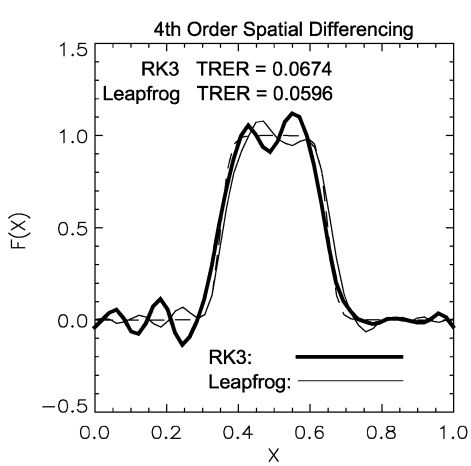

O método converge quando mandamos $h$ e $\Delta x$ para zero? Com que ordem?

In [ ]:
#Tabela
print("Erros")
tab = PrettyTable(['h', 'dx', 'Erro TRER RK3-MPAS', "Razão"])

raz = 1.0
tmp = 0.0
for l in range(0,7):
  #Vamos dobrar o número de passos de tempo e o
  # número de pontos no espaço em cada iteração (2^l)
  dom = Dominio(t0=0, T=2.0, a=0, b=1, n=250*2**l, m=50*2**l)
  prob = TransporteEscalar(v = 1.0)
  lam = prob.v * dom.h/dom.dx
  print(l, " Número de Courant = ", lam)

  #Nossos erros máximos
  u_exata = exata(dom, prob)
  u_mpas = rk33mpas(dom, prob, tend_4ord)
  erro_rk33mpas = np.sqrt(np.sum((u_mpas[:, -1]-u_exata[:,-1])**2)/(dom.m+1))
  if tmp > 0:
    raz = tmp/erro_rk33mpas
  tmp = erro_rk33mpas
  tab.add_row([dom.h, dom.dx, erro_rk33mpas, raz])
  print(tab)



---



## ❗Exercícios ❗

1. Verifique qual o maior número de Courant que podemos usar com o método RK3 com discretização de fluxos de 4a ordem. Para tanto, fixe um valor de $\Delta x$ e varie (aumente) o $h$ progressivamente, observando quando a solução fica instável (erro grande). Para ter segurança se a instabilidade já foi gerada ou não, rode o experimento por períodos mais longos (20 rotações). O valor está próximo do relatado no paper de Wicker & Skamarock 2002?

2. (🧩Opcional) Implemente o método de ordem 6 no espaço para cálculo do Fluxo descrito em Wicker & Skamarock 2002. Teste o método para o mesmo problema do paper e compare com o resultado do paper.



---



**Exercício 1:**



---



**Exercício 2:**